In [1]:

import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")
!pip install facenet-pytorch --no-deps

!pip install pytubefix


# Clean up the notebook
clean_notebook()

Notebook cleaned.


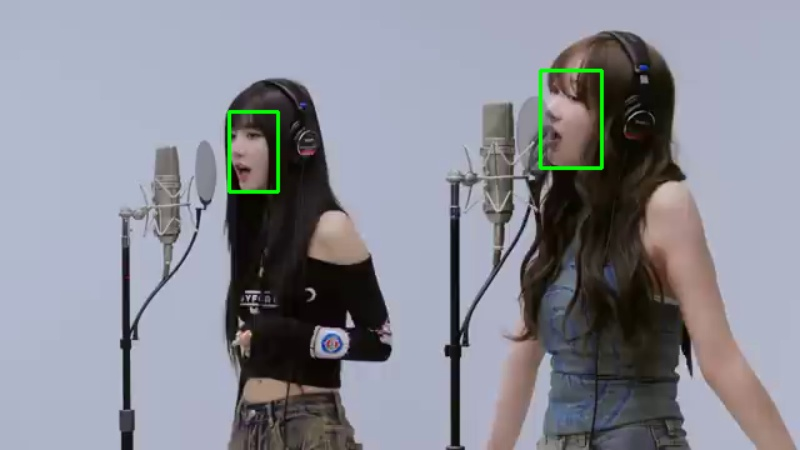

In [ ]:
import cv2
from IPython.display import display, Image, clear_output
import numpy as np
from pytubefix import YouTube
from facenet_pytorch import MTCNN
import torch
import time  # For adding delay

# Initialize MTCNN model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

# YouTube video URL
video_url = "https://youtu.be/EsHQB9gT96k?si=bdi3dDrVnYVIgVYi"

# Target width for resizing
target_width = 800
# Start and stop times in seconds
start_time = 75  # Start at 10 seconds
end_time = 120   # Stop at 120 seconds

# Download the video stream (use pytubefix to fetch the stream URL)
yt = YouTube(video_url)
video_stream = yt.streams.filter(file_extension='mp4', progressive=True).first()

if not video_stream:
    print("No compatible video stream found.")
    exit()

# Get the stream URL
stream_url = video_stream.url

# Open the YouTube stream in OpenCV
cap = cv2.VideoCapture(stream_url)

if not cap.isOpened():
    print("Cannot open YouTube video stream")
    exit()

# Set start time in the video (in milliseconds)
cap.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)

while cap.isOpened():
    clear_output(wait=True)  # Clear previous frame for smoother playback
    ret, frame = cap.read()
    
    if not ret:
        print("Stream stopped.")
        break

    # Get the current playback time in milliseconds
    current_time = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000  # Convert to seconds
    
    # Stop playback if the end time is reached
    if current_time >= end_time:
        print("Reached the specified end time.")
        break

    # Convert frame to RGB format
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Detect faces
    boxes, _ = mtcnn.detect(rgb_frame)

    # Draw bounding boxes on the original frame
    if boxes is not None:
        for box in boxes:
            # Extract coordinates
            x1, y1, x2, y2 = map(int, box)
            # Draw rectangle around face
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Get original dimensions
    original_height, original_width = frame.shape[:2]

    # Calculate aspect ratio and new dimensions
    aspect_ratio = original_height / original_width
    new_height = int(target_width * aspect_ratio)

    # Resize the frame while maintaining the aspect ratio
    resized_frame = cv2.resize(frame, (target_width, new_height))

    # Convert the resized frame to JPEG format for display in Jupyter
    _, buffer = cv2.imencode('.jpg', resized_frame)
    img_bytes = buffer.tobytes()

    # Display the resized frame in Jupyter Notebook
    display(Image(data=img_bytes))
  
    # Add a delay for smoother playback
    time.sleep(0.05)  # Delay in seconds

cap.release()
print("Video stream ended.")
